# 869 Assignment 1 

TODO: Fill in the information below:

- [David, Hu]
- [20249146]
- [Question 1, Task 1]
- [MMA]
- [2021S]
- [MMA869]
- [Dec/13/2020]

<b>Table of Contents</b>
<ul>
    <li><a href="#Settings-and-Functions">Settings and Functions</a></li>
    <li><a href="#Data-Exploration">Data Exploration</a></li>
    <li><a href="#Data-Preparation">Data Preparation</a></li>
    <li><a href="#Visualization">Visualization</a>
    <li><a href="#Algorithms">Algorithms</a>
        <ul>
        <li><a href="#1.-K-means">K-Means</a></li>
        <li><a href="#2.DBSCAN">DBSCAN</a></li>
        <li><a href="#3.-Hierarchical-(Agglomerative)">Hierarchical (Agglomerative)</a></li>
        </ul>
    </li>
</ul>

In [1]:
# Do not change this cell

import datetime
print(datetime.datetime.now())

2020-12-10 23:34:09.926094


In [2]:
# Do not change this cell

import pandas as pd
import numpy as np
import sklearn

print('scikit-learn: {}'.format(sklearn.__version__))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

scikit-learn: 0.23.2
pandas: 1.1.3
numpy: 1.19.2


In [3]:
# Do not change this cell

import os
os.getcwd()

"/Users/dvdhoo/OneDrive - Queen's University/MMA/MMA 869/Individual Assignment/Answers"

In [4]:
# TODO: Import other packages as necessary

import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

import scipy.cluster

In [5]:
# Read in the data
df = pd.read_csv("../jewelry_customers.csv") # or whatever file you need

In [6]:
# TODO: continue here to perform the given task. 
# Don't forget to document your code!
# Use as many cells as you'd like!
# Don't print out large volumes of output!
# Don't forget to save/export as PDF!
# Make sure to always run all cells in order! Always restart kernel and run all cells before creating the PDF

# Settings and Functions

In [7]:
# Default plot settings

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16


plt.rc('figure', figsize=[8.0, 5.0])     # controls the size of the figure
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', grid=True)

In [8]:
# Cluster Plotting Helper

def plot_cluster(X, i, method = 'default', size_sil = False):
    i = i
    X_index = X.columns
    method = method
    if method == 'default':
        color = 'black'
        sizes = 20
    elif size_sil:
        color = method.labels_
        sample_silhouette_values = silhouette_samples(X, method.labels_)
        sizes = 20*(2-sample_silhouette_values)
    else:
        color = method.labels_
        sample_silhouette_values = silhouette_samples(X, method.labels_)
        sizes = 20

    if i >= len(X_index):
        print('Error: Index too large!')
        return


    plt.figure()

    plt.scatter(X.iloc[:, i], X.iloc[:, 0], s=sizes, c=color)
    
    if str(method).partition("(")[0] == 'KMeans':
        plt.scatter(method.cluster_centers_[:, i], method.cluster_centers_[:, 0], marker='x', s=200, c="black")

    plt.title("Jewelry Customer Data");
    plt.xlabel(X_index[i]);
    plt.ylabel(X_index[0]);

In [9]:
# Print Summary Stats Helper

def describe_clusters(X_cluster, scaler, scaler_features):
    X_df = pd.DataFrame(scaler.inverse_transform(X_cluster[scaler_features]), columns=scaler_features)
    X_df = X_df.merge(X_cluster['SpendingScore'], left_index=True, right_index=True)
    X_df['Cluster'] = X_cluster['Cluster ID']
    display(X_df.groupby(['Cluster']).agg('mean'))

    cl_group = X_df.groupby(['Cluster']).agg('describe')
    #cl_group
    #cl_group.info()

    for item in ['Age', 'Income', 'Savings', 'SpendingScore']:
        print('======================================================================\n')
        print('Stats for {}:\n'.format(item))
        display(cl_group[item])

# Data Exploration

In [10]:
df

,Age,Income,SpendingScore,Savings
0,58,77769,0.791329,6559.829923
1,59,81799,0.791082,5417.661426
2,62,74751,0.702657,9258.992965
3,59,74373,0.765680,7346.334504
4,87,17760,0.348778,16869.507130
...,...,...,...,...
500,28,101206,0.387441,14936.775389
501,93,19934,0.203140,17969.693769
502,90,35297,0.355149,16091.401954
503,91,20681,0.354679,18401.088445


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            505 non-null    int64  
 1   Income         505 non-null    int64  
 2   SpendingScore  505 non-null    float64
 3   Savings        505 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 15.9 KB


In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,505.0,59.019802,24.140043,17.0,34.000000,59.000000,85.000000,97.0
Income,505.0,75513.291089,35992.922184,12000.0,34529.000000,75078.000000,107100.000000,142000.0
SpendingScore,505.0,0.505083,0.259634,0.0,0.304792,0.368215,0.768279,1.0
Savings,505.0,11862.455867,4949.229253,0.0,6828.709702,14209.932802,16047.268331,20000.0


In [13]:
df.corr()

,Age,Income,SpendingScore,Savings
Age,1.000000,-0.828457,-0.329116,0.412337
Income,-0.828457,1.000000,0.196111,-0.410774
SpendingScore,-0.329116,0.196111,1.000000,-0.915379
Savings,0.412337,-0.410774,-0.915379,1.000000


# Data Preparation

In [14]:
X = df[['SpendingScore', 'Age', 'Income', 'Savings']]

# Normalize data for better clustering

scaler = StandardScaler()
features = ['Age', 'Income', 'Savings']
X[features] = scaler.fit_transform(X[features])

# Visualization

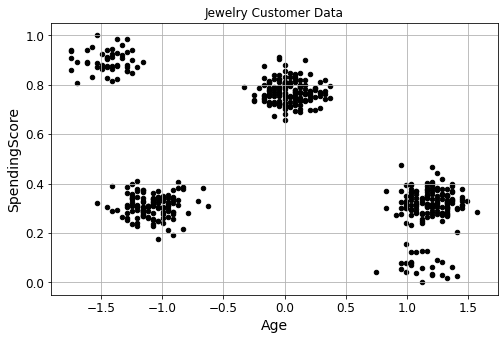

In [15]:
plot_cluster(X, 1)

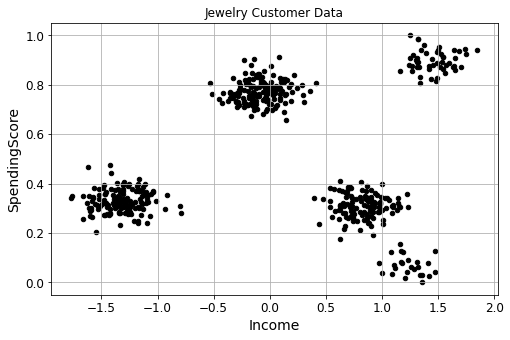

In [16]:
plot_cluster(X, 2)

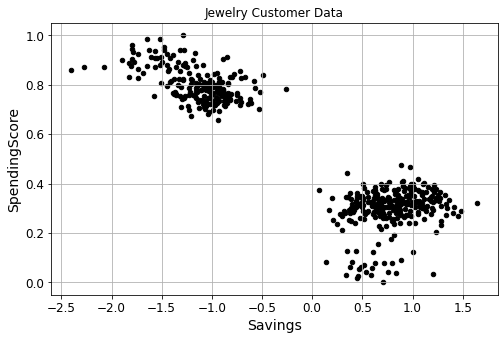

In [17]:
plot_cluster(X, 3)

# Algorithms

## 1. K-means

<b>Hyperparameter Tuning

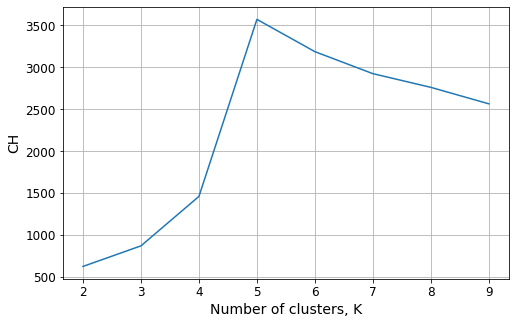

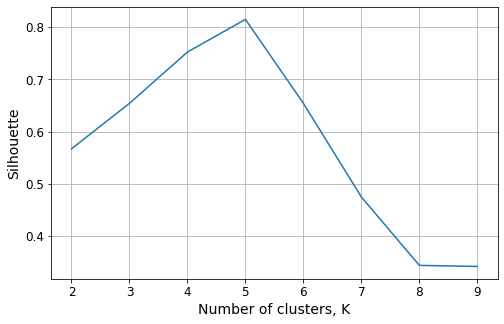

In [18]:
chs = {}
silhouettes = {}
        
for k in range(2,10):
    k_means_tun = KMeans(init='k-means++', n_clusters=k, n_init=10, random_state=42)
    k_means_tun.fit(X)
    sil = silhouette_score(X, k_means_tun.labels_,  metric='euclidean')
    ch = calinski_harabasz_score(X, k_means_tun.labels_)
    chs[k] = ch
    silhouettes[k] = sil
    
    
plt.figure();
plt.plot(list(chs.keys()), list(chs.values()));
#plt.title('K-Means')
plt.xlabel("Number of clusters, K");
plt.ylabel("CH");
#plt.savefig('out/elbow_ch.png');
plt.show();


plt.figure();
plt.plot(list(silhouettes.keys()), list(silhouettes.values()));
#plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Silhouette");
#plt.savefig('out/elbow_sil.png');
plt.show();

<b>Model

In [19]:
# Best number of clusters is 5
k_means = KMeans(n_clusters=5, random_state=42)
k_means.fit(X)

KMeans(n_clusters=5, random_state=42)

In [20]:
# Clustering result
k_means_result = k_means.labels_

In [21]:
# Clustering Measures
silhouette_score(X, k_means_result)
calinski_harabasz_score(X, k_means_result)

0.8151726250338607

3571.1798244260194

In [22]:
sample_silhouette_values = silhouette_samples(X, k_means_result)

X_tmp = X.copy()
X_tmp['Cluster ID'] = k_means_result

X_tmp['Silhouette'] = sample_silhouette_values
X_k_means = X_tmp.copy()

In [23]:
X_k_means

,SpendingScore,Age,Income,Savings,Cluster ID,Silhouette
0,0.791329,-0.042287,0.062733,-1.072467,1,0.838232
1,0.791082,-0.000821,0.174811,-1.303473,1,0.758127
2,0.702657,0.123577,-0.021200,-0.526556,1,0.711200
3,0.765680,-0.000821,-0.031712,-0.913395,1,0.857219
4,0.348778,1.160228,-1.606165,1.012686,0,0.853087
...,...,...,...,...,...,...
500,0.387441,-1.286268,0.714535,0.621787,3,0.835669
501,0.203140,1.409024,-1.545704,1.235201,0,0.822068
502,0.355149,1.284626,-1.118447,0.855313,0,0.834961
503,0.354679,1.326092,-1.524929,1.322452,0,0.824131


<b>Interpretation

In [24]:
# centers
k_means_clusters = pd.DataFrame(k_means.cluster_centers_, columns=X.columns)
k_means_clusters

,SpendingScore,Age,Income,Savings
0,0.328800,1.192385,-1.325106,0.970164
1,0.771518,0.038796,-0.085246,-1.005695
2,0.068378,1.118762,1.235654,0.595881
3,0.309926,-1.088152,0.827441,0.627046
4,0.896892,-1.444668,1.460507,-1.572496


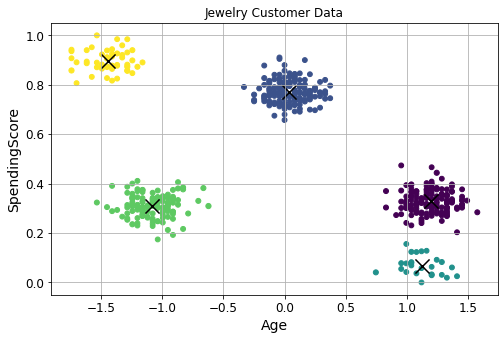

In [25]:
plot_cluster(X, 1, k_means, size_sil = True)

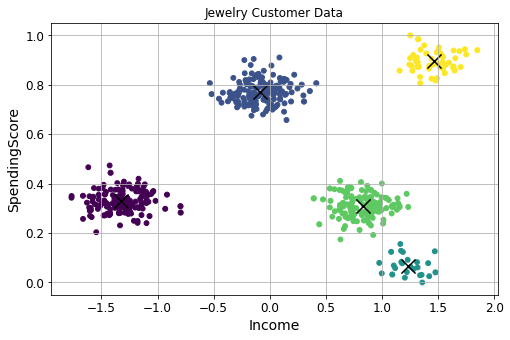

In [26]:
plot_cluster(X, 2, k_means, size_sil = True)

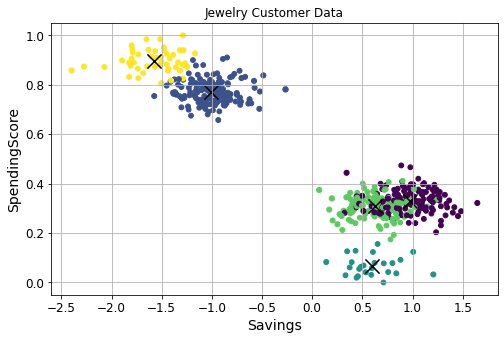

In [27]:
plot_cluster(X, 3, k_means, size_sil = True)

In [28]:
# Summary stats
describe_clusters(X_k_means, scaler, features)

,Age,Income,Savings,SpendingScore
Cluster,,,,
0,87.775510,27866.102041,16659.261445,0.328800
1,59.955414,72448.063694,6889.972190,0.771518
2,86.000000,119944.040000,14808.683793,0.068378
3,32.777778,105265.809524,14962.778066,0.309926
4,24.180000,128029.120000,4087.520309,0.896892



Stats for Age:



,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,147.0,87.775510,3.508885,79.0,85.0,88.0,91.0,97.0
1,157.0,59.955414,3.376662,51.0,58.0,59.0,62.0,68.0
2,25.0,86.000000,3.662877,77.0,84.0,86.0,88.0,93.0
3,126.0,32.777778,3.792390,22.0,30.0,33.0,35.0,44.0
4,50.0,24.180000,3.662775,17.0,22.0,24.5,27.0,31.0



Stats for Income:



,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,147.0,27866.102041,6448.805481,12000.0,23361.00,27771.0,32601.00,46977.0
1,157.0,72448.063694,6240.260008,56321.0,68463.00,72027.0,76594.00,90422.0
2,25.0,119944.040000,4941.052254,110582.0,117347.00,119429.0,123651.00,128596.0
3,126.0,105265.809524,6080.621753,89598.0,100760.25,106002.5,108858.75,119877.0
4,50.0,128029.120000,5688.904656,117108.0,123042.00,128162.0,131435.75,142000.0



Stats for Savings:



,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,147.0,16659.261445,1183.850178,13470.970605,15957.282919,16711.067980,17433.126684,20000.000000
1,157.0,6889.972190,1052.276354,4077.658657,6225.376082,6845.056822,7497.231607,10547.775368
2,25.0,14808.683793,1159.339639,12554.692742,14047.388986,14773.407206,15391.952192,17833.093470
3,126.0,14962.778066,1061.734017,12207.526078,14223.787562,14976.943192,15682.288845,17968.553929
4,50.0,4087.520309,1277.754801,0.000000,3275.320193,4361.967019,4986.863329,6089.478323



Stats for SpendingScore:



,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,147.0,0.328800,0.045224,0.203140,0.301502,0.324719,0.357267,0.473550
1,157.0,0.771518,0.046058,0.657314,0.740367,0.766720,0.800598,0.910417
2,25.0,0.068378,0.039744,0.000000,0.036795,0.063273,0.082723,0.155694
3,126.0,0.309926,0.045513,0.174120,0.281237,0.309479,0.341096,0.411112
4,50.0,0.896892,0.043466,0.806553,0.871957,0.890676,0.926473,1.000000


## 2.DBSCAN

<b>Hyperparameter Tuning

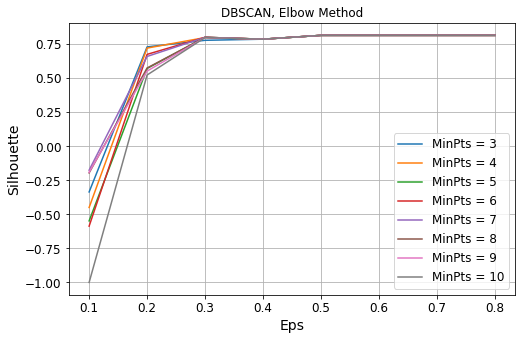

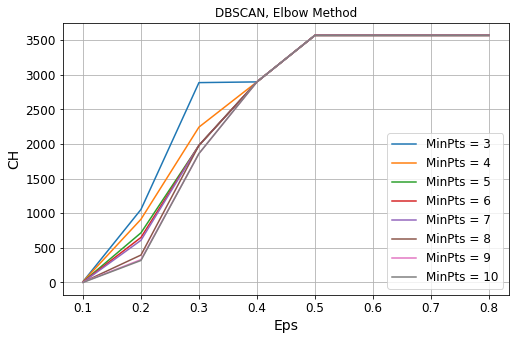

In [29]:
silhouettes = {}

epss = np.arange(0.1, 0.9, 0.1)
minss = [3, 4, 5, 6, 7, 8, 9, 10]

ss = np.zeros((len(epss), len(minss)))
ch = np.zeros((len(epss), len(minss)))

for i, eps in enumerate(epss):
    for j, mins in enumerate(minss):
        db = DBSCAN(eps=eps, min_samples=mins).fit(X)
        if len(set(db.labels_)) == 1:
            ss[i, j] = -1
            ch[i, j] = 0
        else:
            ss[i, j] = silhouette_score(X, db.labels_, metric='euclidean')
            ch[i, j] = calinski_harabasz_score(X, db.labels_)
    

plt.figure();
#plt.plot(list(silhouettes.keys()), list(silhouettes.values()));
for i in range(len(minss)):
    plt.plot(epss, ss[:, i], label="MinPts = {}".format(minss[i]));
#plt.plot(epss, ss[:, 1]);
plt.title('DBSCAN, Elbow Method')
plt.xlabel("Eps");
plt.ylabel("Silhouette");
plt.legend();
#plt.savefig('out/simple_dbscan_elbow.png');
plt.show()


plt.figure();
for i in range(len(minss)):
    plt.plot(epss, ch[:, i], label="MinPts = {}".format(minss[i]))
plt.title('DBSCAN, Elbow Method')
plt.xlabel("Eps");
plt.ylabel("CH");
plt.legend();
#plt.savefig('out/elbow_ch.png');
plt.show();

<b>Model

In [30]:
# Best eps is 0.5
db = DBSCAN(eps=0.5, min_samples=3)
db.fit(X)

DBSCAN(min_samples=3)

In [31]:
# Clustering result
db_result = db.labels_

In [32]:
# Clustering measures
silhouette_score(X, db_result)
calinski_harabasz_score(X, db_result)

0.8151726250338607

3571.1798244260194

In [33]:
sample_silhouette_values = silhouette_samples(X, db_result)

X_tmp = X.copy()
X_tmp['Cluster ID'] = db_result

X_tmp['Silhouette'] = sample_silhouette_values
X_db = X_tmp.copy()

In [34]:
X_db

,SpendingScore,Age,Income,Savings,Cluster ID,Silhouette
0,0.791329,-0.042287,0.062733,-1.072467,0,0.838232
1,0.791082,-0.000821,0.174811,-1.303473,0,0.758127
2,0.702657,0.123577,-0.021200,-0.526556,0,0.711200
3,0.765680,-0.000821,-0.031712,-0.913395,0,0.857219
4,0.348778,1.160228,-1.606165,1.012686,1,0.853087
...,...,...,...,...,...,...
500,0.387441,-1.286268,0.714535,0.621787,4,0.835669
501,0.203140,1.409024,-1.545704,1.235201,1,0.822068
502,0.355149,1.284626,-1.118447,0.855313,1,0.834961
503,0.354679,1.326092,-1.524929,1.322452,1,0.824131


<b>Interpretation

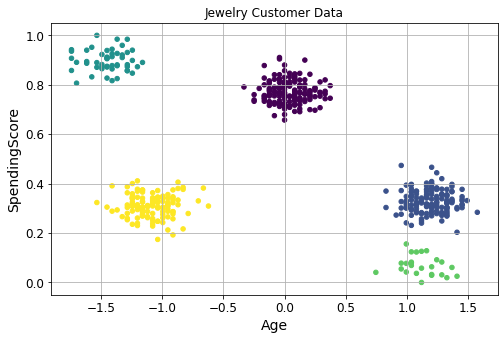

In [35]:
plot_cluster(X, 1, db)

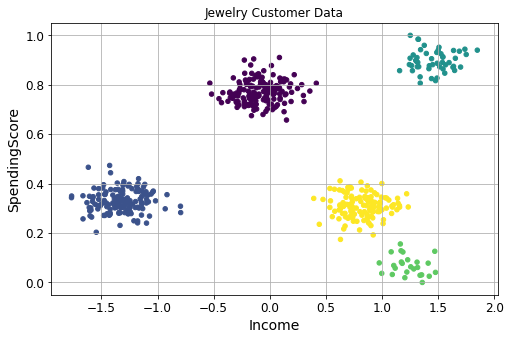

In [36]:
plot_cluster(X, 2, db)

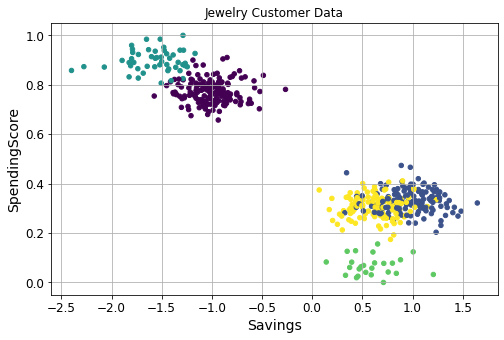

In [37]:
plot_cluster(X, 3, db)

In [38]:
# Summary Stats
describe_clusters(X_db, scaler, features)

,Age,Income,Savings,SpendingScore
Cluster,,,,
0,59.955414,72448.063694,6889.972190,0.771518
1,87.775510,27866.102041,16659.261445,0.328800
2,24.180000,128029.120000,4087.520309,0.896892
3,86.000000,119944.040000,14808.683793,0.068378
4,32.777778,105265.809524,14962.778066,0.309926



Stats for Age:



,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,157.0,59.955414,3.376662,51.0,58.0,59.0,62.0,68.0
1,147.0,87.775510,3.508885,79.0,85.0,88.0,91.0,97.0
2,50.0,24.180000,3.662775,17.0,22.0,24.5,27.0,31.0
3,25.0,86.000000,3.662877,77.0,84.0,86.0,88.0,93.0
4,126.0,32.777778,3.792390,22.0,30.0,33.0,35.0,44.0



Stats for Income:



,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,157.0,72448.063694,6240.260008,56321.0,68463.00,72027.0,76594.00,90422.0
1,147.0,27866.102041,6448.805481,12000.0,23361.00,27771.0,32601.00,46977.0
2,50.0,128029.120000,5688.904656,117108.0,123042.00,128162.0,131435.75,142000.0
3,25.0,119944.040000,4941.052254,110582.0,117347.00,119429.0,123651.00,128596.0
4,126.0,105265.809524,6080.621753,89598.0,100760.25,106002.5,108858.75,119877.0



Stats for Savings:



,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,157.0,6889.972190,1052.276354,4077.658657,6225.376082,6845.056822,7497.231607,10547.775368
1,147.0,16659.261445,1183.850178,13470.970605,15957.282919,16711.067980,17433.126684,20000.000000
2,50.0,4087.520309,1277.754801,0.000000,3275.320193,4361.967019,4986.863329,6089.478323
3,25.0,14808.683793,1159.339639,12554.692742,14047.388986,14773.407206,15391.952192,17833.093470
4,126.0,14962.778066,1061.734017,12207.526078,14223.787562,14976.943192,15682.288845,17968.553929



Stats for SpendingScore:



,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,157.0,0.771518,0.046058,0.657314,0.740367,0.766720,0.800598,0.910417
1,147.0,0.328800,0.045224,0.203140,0.301502,0.324719,0.357267,0.473550
2,50.0,0.896892,0.043466,0.806553,0.871957,0.890676,0.926473,1.000000
3,25.0,0.068378,0.039744,0.000000,0.036795,0.063273,0.082723,0.155694
4,126.0,0.309926,0.045513,0.174120,0.281237,0.309479,0.341096,0.411112


## 3. Hierarchical (Agglomerative)

<b>Hyperparameter Tuning

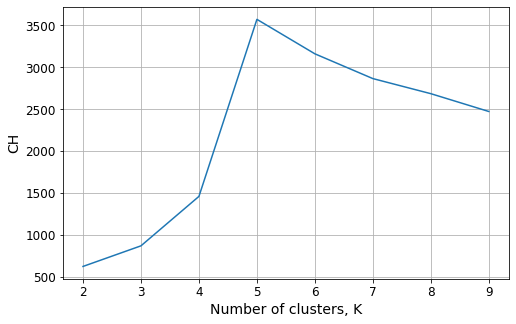

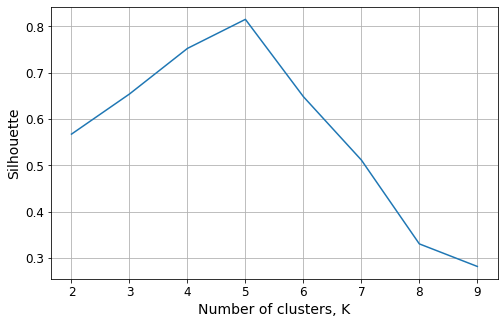

In [39]:
chs = {}
silhouettes = {}
        
for k in range(2,10):
    agg_tun = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    agg_tun.fit(X)
    sil = silhouette_score(X, agg_tun.labels_,  metric='euclidean')
    ch = calinski_harabasz_score(X, agg_tun.labels_)
    chs[k] = ch
    silhouettes[k] = sil
    
    
plt.figure();
plt.plot(list(chs.keys()), list(chs.values()));
#plt.title('K-Means')
plt.xlabel("Number of clusters, K");
plt.ylabel("CH");
#plt.savefig('out/elbow_ch.png');
plt.show();


plt.figure();
plt.plot(list(silhouettes.keys()), list(silhouettes.values()));
#plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Silhouette");
#plt.savefig('out/elbow_sil.png');
plt.show();

<b>Model

In [40]:
# Best number of clusters is 5
agg = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agg.fit(X)

AgglomerativeClustering(n_clusters=5)

In [41]:
# Clustering Result
agg_result = agg.labels_

In [42]:
# Clustering measures
silhouette_score(X, agg_result)
calinski_harabasz_score(X, agg_result)

0.8151726250338607

3571.1798244260194

In [43]:
sample_silhouette_values = silhouette_samples(X, agg_result)

X_tmp = X.copy()
X_tmp['Cluster ID'] = agg_result

X_tmp['Silhouette'] = sample_silhouette_values
X_agg = X_tmp.copy()

In [44]:
X_agg

,SpendingScore,Age,Income,Savings,Cluster ID,Silhouette
0,0.791329,-0.042287,0.062733,-1.072467,2,0.838232
1,0.791082,-0.000821,0.174811,-1.303473,2,0.758127
2,0.702657,0.123577,-0.021200,-0.526556,2,0.711200
3,0.765680,-0.000821,-0.031712,-0.913395,2,0.857219
4,0.348778,1.160228,-1.606165,1.012686,0,0.853087
...,...,...,...,...,...,...
500,0.387441,-1.286268,0.714535,0.621787,1,0.835669
501,0.203140,1.409024,-1.545704,1.235201,0,0.822068
502,0.355149,1.284626,-1.118447,0.855313,0,0.834961
503,0.354679,1.326092,-1.524929,1.322452,0,0.824131


<b>Interpretation

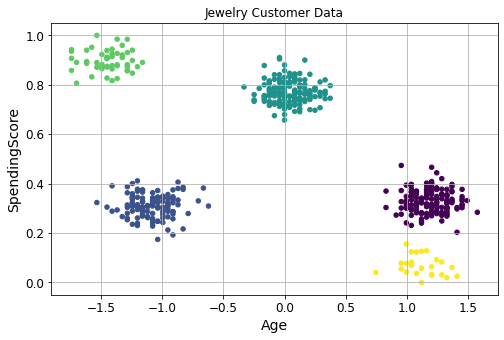

In [45]:
plot_cluster(X, 1, agg)

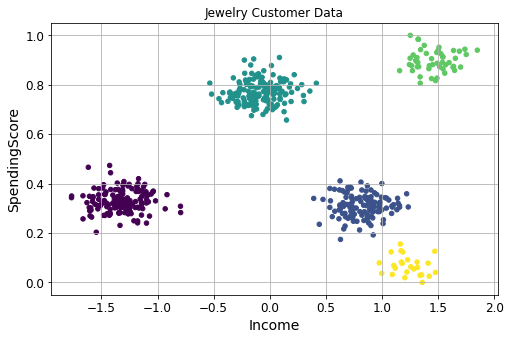

In [46]:
plot_cluster(X, 2, agg)

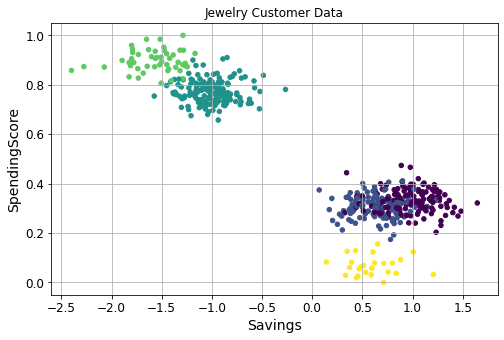

In [47]:
plot_cluster(X, 3, agg)

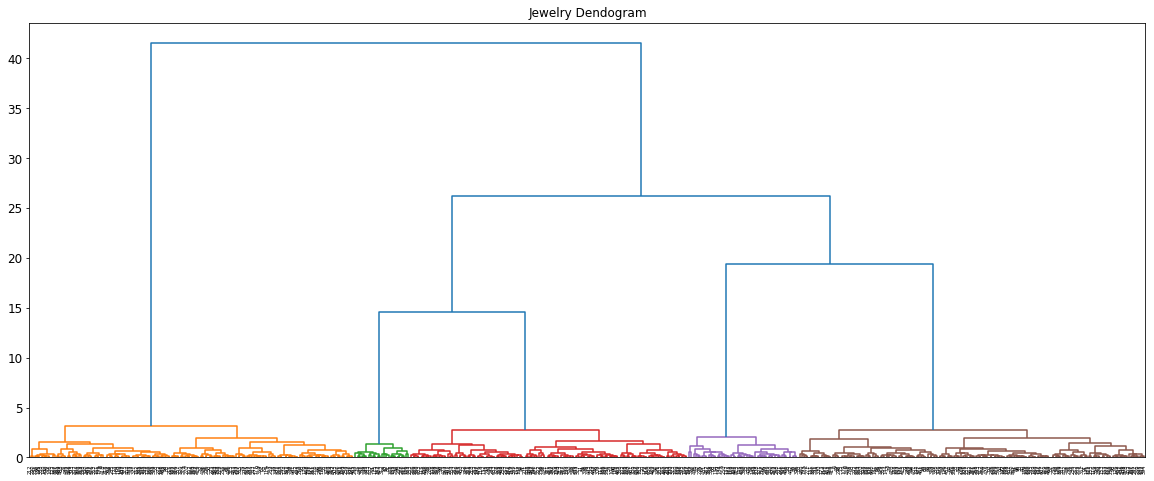

In [48]:
# Plot the dendogram

aggl = scipy.cluster.hierarchy.linkage(X, method='ward', metric='euclidean')

plt.figure(figsize=(20, 8));
plt.grid(False)
plt.title("Jewelry Dendogram");  
dend = scipy.cluster.hierarchy.dendrogram(aggl, color_threshold=5);

In [49]:
# Summary Stats
describe_clusters(X_agg, scaler, features)

,Age,Income,Savings,SpendingScore
Cluster,,,,
0,87.775510,27866.102041,16659.261445,0.328800
1,32.777778,105265.809524,14962.778066,0.309926
2,59.955414,72448.063694,6889.972190,0.771518
3,24.180000,128029.120000,4087.520309,0.896892
4,86.000000,119944.040000,14808.683793,0.068378



Stats for Age:



,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,147.0,87.775510,3.508885,79.0,85.0,88.0,91.0,97.0
1,126.0,32.777778,3.792390,22.0,30.0,33.0,35.0,44.0
2,157.0,59.955414,3.376662,51.0,58.0,59.0,62.0,68.0
3,50.0,24.180000,3.662775,17.0,22.0,24.5,27.0,31.0
4,25.0,86.000000,3.662877,77.0,84.0,86.0,88.0,93.0



Stats for Income:



,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,147.0,27866.102041,6448.805481,12000.0,23361.00,27771.0,32601.00,46977.0
1,126.0,105265.809524,6080.621753,89598.0,100760.25,106002.5,108858.75,119877.0
2,157.0,72448.063694,6240.260008,56321.0,68463.00,72027.0,76594.00,90422.0
3,50.0,128029.120000,5688.904656,117108.0,123042.00,128162.0,131435.75,142000.0
4,25.0,119944.040000,4941.052254,110582.0,117347.00,119429.0,123651.00,128596.0



Stats for Savings:



,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,147.0,16659.261445,1183.850178,13470.970605,15957.282919,16711.067980,17433.126684,20000.000000
1,126.0,14962.778066,1061.734017,12207.526078,14223.787562,14976.943192,15682.288845,17968.553929
2,157.0,6889.972190,1052.276354,4077.658657,6225.376082,6845.056822,7497.231607,10547.775368
3,50.0,4087.520309,1277.754801,0.000000,3275.320193,4361.967019,4986.863329,6089.478323
4,25.0,14808.683793,1159.339639,12554.692742,14047.388986,14773.407206,15391.952192,17833.093470



Stats for SpendingScore:



,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,147.0,0.328800,0.045224,0.203140,0.301502,0.324719,0.357267,0.473550
1,126.0,0.309926,0.045513,0.174120,0.281237,0.309479,0.341096,0.411112
2,157.0,0.771518,0.046058,0.657314,0.740367,0.766720,0.800598,0.910417
3,50.0,0.896892,0.043466,0.806553,0.871957,0.890676,0.926473,1.000000
4,25.0,0.068378,0.039744,0.000000,0.036795,0.063273,0.082723,0.155694
